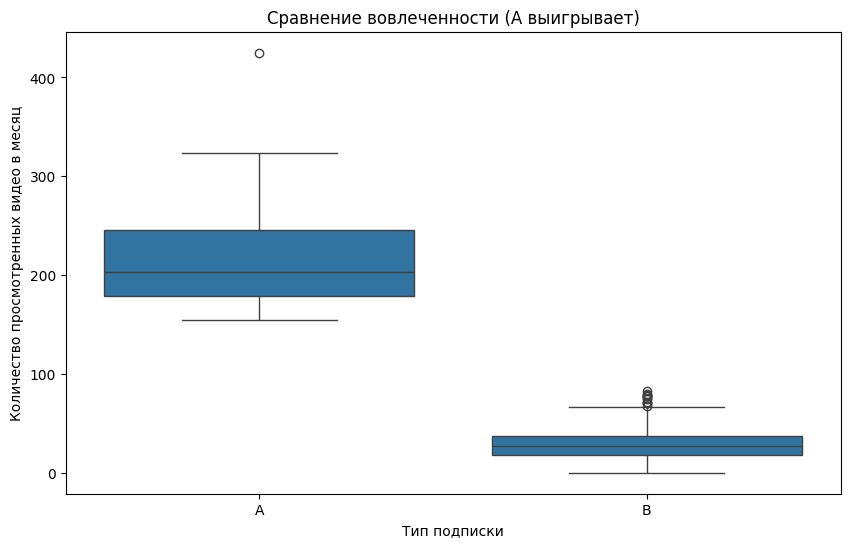

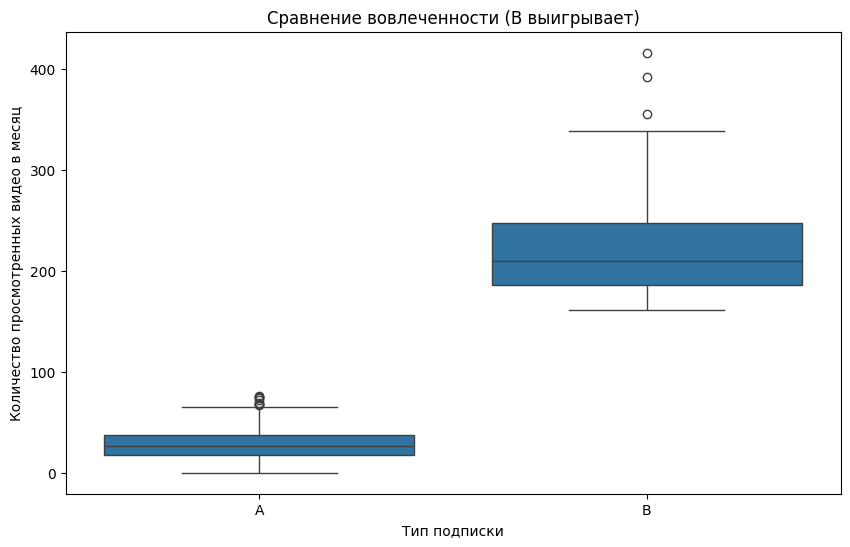

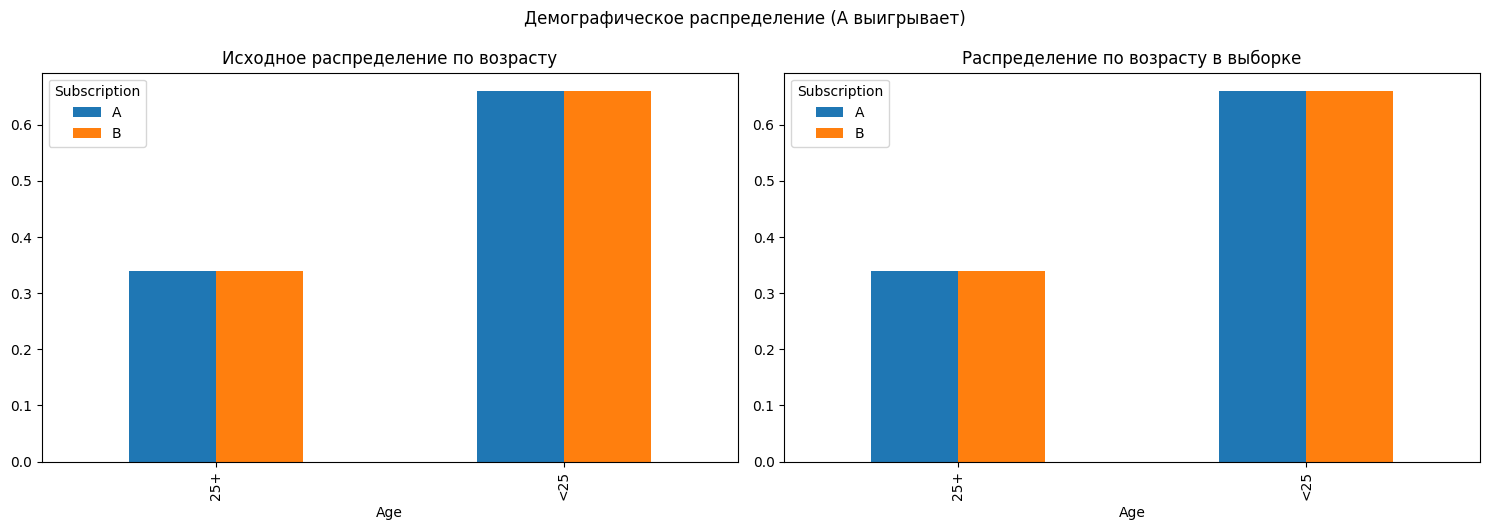

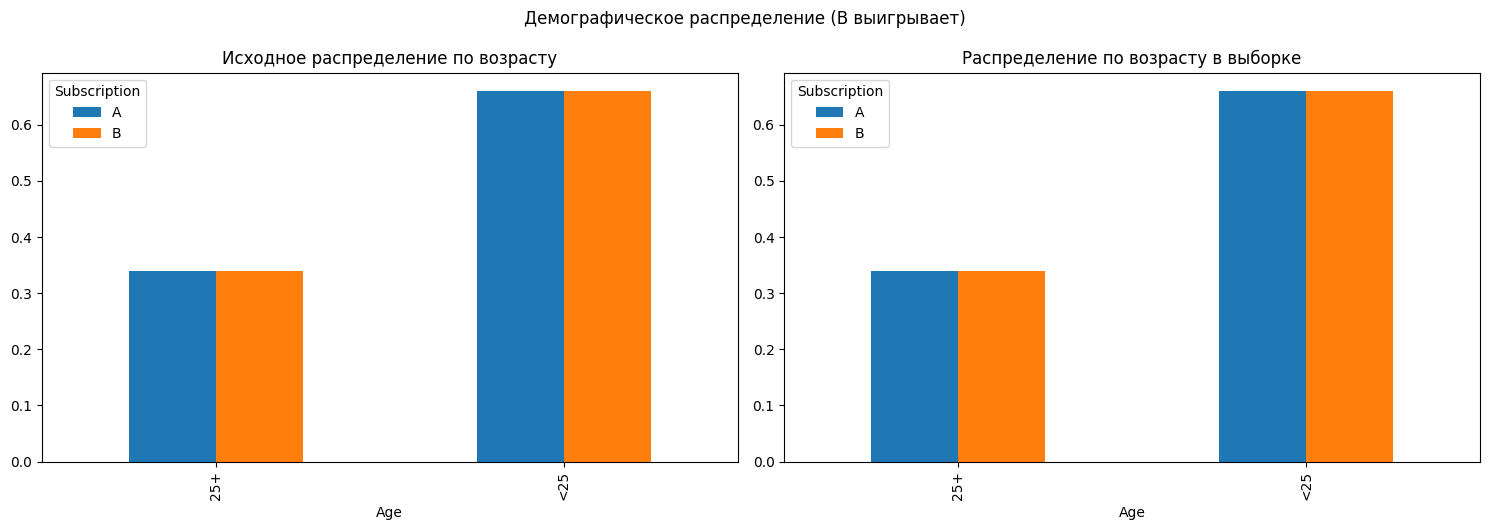


Статистика для сценария, где A выигрывает:
   Age  Gender Subscription  count    mean    std
0  25+  Female            A     40   41.42   6.89
1  25+  Female            B     40   17.45   6.42
2  25+    Male            A     28   29.57   5.80
3  25+    Male            B     28    9.29   6.19
4  <25  Female            A     72  204.07  29.95
5  <25  Female            B     72   88.81  29.54
6  <25    Male            A     60  269.83  37.41
7  <25    Male            B     60  145.40  41.38

Статистика для сценария, где B выигрывает:
   Age  Gender Subscription  count    mean    std
0  25+  Female            A     40   17.80   5.05
1  25+  Female            B     40   41.88   8.65
2  25+    Male            A     28   11.21   5.78
3  25+    Male            B     28   30.71   4.62
4  <25  Female            A     72   93.50  33.25
5  <25  Female            B     72  209.29  33.28
6  <25    Male            A     60  132.22  47.12
7  <25    Male            B     60  271.77  41.81


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

def load_data(url):
    df = pd.read_csv(url)
    return df

def create_biased_selection(df, winner_product, n_select=200):
    prod_a = df[df['Subscription'] == 'A'].copy()
    prod_b = df[df['Subscription'] == 'B'].copy()
    
    if winner_product == 'A':
        selected_a = prod_a.nlargest(n_select, 'Videos Watched')
        selected_b = prod_b.nsmallest(n_select, 'Videos Watched')
    else:
        selected_a = prod_a.nsmallest(n_select, 'Videos Watched')
        selected_b = prod_b.nlargest(n_select, 'Videos Watched')
    
    return pd.concat([selected_a, selected_b])

def create_balanced_selection(df, winner_product, n_select=200):
    selections = []
    
    for age in df['Age'].unique():
        for gender in df['Gender'].unique():
            mask = (df['Age'] == age) & (df['Gender'] == gender)
            demo_df = df[mask]
            
            prop_a = len(demo_df[demo_df['Subscription'] == 'A']) / len(df[df['Subscription'] == 'A'])
            prop_b = len(demo_df[demo_df['Subscription'] == 'B']) / len(df[df['Subscription'] == 'B'])
            
            n_select_a = int(n_select * prop_a)
            n_select_b = int(n_select * prop_b)
            
            demo_a = demo_df[demo_df['Subscription'] == 'A']
            demo_b = demo_df[demo_df['Subscription'] == 'B']
            
            if winner_product == 'A':
                selected_a = demo_a.nlargest(n_select_a, 'Videos Watched')
                selected_b = demo_b.nsmallest(n_select_b, 'Videos Watched')
            else:
                selected_a = demo_a.nsmallest(n_select_a, 'Videos Watched')
                selected_b = demo_b.nlargest(n_select_b, 'Videos Watched')
                
            selections.append(pd.concat([selected_a, selected_b]))
    
    return pd.concat(selections)

def plot_engagement_comparison(data, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Subscription', y='Videos Watched', data=data)
    plt.title(title)
    plt.ylabel('Количество просмотренных видео в месяц')
    plt.xlabel('Тип подписки')
    plt.show()

def plot_demographic_distribution(original_df, selected_df, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    pd.crosstab(original_df['Age'], original_df['Subscription'], normalize='columns').plot(
        kind='bar', ax=ax1, title='Исходное распределение по возрасту'
    )
    pd.crosstab(selected_df['Age'], selected_df['Subscription'], normalize='columns').plot(
        kind='bar', ax=ax2, title='Распределение по возрасту в выборке'
    )
    
    plt.tight_layout()
    plt.suptitle(title, y=1.05)
    plt.show()

def generate_demographic_stats(df):
    stats_df = df.groupby(['Age', 'Gender', 'Subscription'])['Videos Watched'].agg([
        'count', 'mean', 'std'
    ]).round(2).reset_index()
    return stats_df

def main():
    url = "https://raw.githubusercontent.com/zalig/cu-datasets/main/without_rules.csv"
    df = load_data(url)
    
    selection_a_wins = create_biased_selection(df, 'A')
    selection_b_wins = create_biased_selection(df, 'B')
    
    balanced_a_wins = create_balanced_selection(df, 'A')
    balanced_b_wins = create_balanced_selection(df, 'B')
    
    df['Selection Winner A'] = df.index.isin(selection_a_wins.index).astype(int)
    df['Selection Winner B'] = df.index.isin(selection_b_wins.index).astype(int)
    
    plot_engagement_comparison(selection_a_wins, 'Сравнение вовлеченности (A выигрывает)')
    plot_engagement_comparison(selection_b_wins, 'Сравнение вовлеченности (B выигрывает)')
    
    plot_demographic_distribution(df, balanced_a_wins, 'Демографическое распределение (A выигрывает)')
    plot_demographic_distribution(df, balanced_b_wins, 'Демографическое распределение (B выигрывает)')
    
    stats_a_wins = generate_demographic_stats(balanced_a_wins)
    stats_b_wins = generate_demographic_stats(balanced_b_wins)
    
    print("\nСтатистика для сценария, где A выигрывает:")
    print(stats_a_wins)
    print("\nСтатистика для сценария, где B выигрывает:")
    print(stats_b_wins)
    
    return df, stats_a_wins, stats_b_wins

if __name__ == "__main__":
    df, stats_a_wins, stats_b_wins = main()

#Presentation
https://docs.google.com/presentation/d/1ly9sLeBvKPg_0_nHfhBXYu2NAWu4kU94LY2anlKXSw0/edit?usp=sharing